In [1]:
%load_ext autoreload
%autoreload 2
import torch
from solver.edl_solver import Solver
from models.cnn_transformer import get_resnet_transformer
from models.resnet101_3d_cnn import get_resnet101_3d
from dataset.subset_loader import GestureSubset
from torch.utils.data import DataLoader
from models.utils import count_trainable_parameters
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import os
import numpy as np
import json

from edl_playground.edl.losses import (
    LinearAnnealingFactor, ExpAnnealingFactor,
    Type2MaximumLikelihoodLoss, BayesRiskForCrossEntropyLoss, BayesRiskForSSELoss,
    KL_Divergence_RegularizationLoss, EUC_RegularizationLoss,
)
from edl_playground.edl.distribution import plot_model_uncertainty_distribution

In [2]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
annotations_train = "Annot_TrainList.txt"
annotations_test = "Annot_TestList.txt"

path_annotations_train = os.path.join(".", "IPN_Hand", "annotations", annotations_train)
path_annotations_test = os.path.join(".", "IPN_Hand", "annotations", annotations_test)
path_frames = os.path.join(".", "IPN_Hand", "hand_gestures.h5")

path_to_save = "cnn_trans_edl.pth"


In [4]:
# transform = transforms.Compose([
# transforms.ToTensor()
# ])

# SAMPLE_DURATION = 4

# ds_train = GestureSubset(path_frames, path_annotations_train, transform, sample_duration=SAMPLE_DURATION)
# ds_test = GestureSubset(path_frames, path_annotations_test, transform, sample_duration=SAMPLE_DURATION)

# from collections import Counter

# print(Counter([s[1] for s in ds_train]))  # Counter({0: 922, 1: 745, 2: 743, 3: 148, 4: 148, 5: 148, 6: 149, 7: 148, 8: 148, 9: 148, 10: 148, 11: 148, 12: 148, 13: 148})
# print(Counter([s[1] for s in ds_test]))   # Counter({0: 509, 1: 265, 2: 264, 3: 52, 4: 52, 5: 52, 6: 52, 7: 52, 8: 52, 9: 52, 10: 52, 11: 52, 12: 52, 13: 52})
# counter.most_common()
# sorted(counter.items())

In [5]:
BALANCED = False
UNFREEZE_LAYERS = [
    # [1, 5],
    [1, 8],
]

In [6]:
transform = transforms.Compose([
transforms.ToTensor()
])

BATCH_SIZE = 8
CLASS_IDS = list(range(5))
no_of_classes = len(CLASS_IDS)
if BALANCED:
    N_SAMPLES_PER_CLASS_TRAIN = (BATCH_SIZE * 2 * np.array([3, 3, 3, 3, 3])).tolist()
else:
    N_SAMPLES_PER_CLASS_TRAIN = (BATCH_SIZE * 2 * np.array([6, 5, 5, 1, 1])).tolist()
N_SAMPLES_PER_CLASS_TEST = (BATCH_SIZE * 2 * np.array([10, 5, 5, 1, 1])).tolist()
SAMPLE_DURATION = 4

ds_train = GestureSubset(path_frames, path_annotations_train, transform, sample_duration=SAMPLE_DURATION, class_ids=CLASS_IDS, n_samples_per_class=N_SAMPLES_PER_CLASS_TRAIN)
ds_test = GestureSubset(path_frames, path_annotations_test, transform, sample_duration=SAMPLE_DURATION, class_ids=CLASS_IDS, n_samples_per_class=N_SAMPLES_PER_CLASS_TEST)

In [7]:
len(GestureSubset(path_frames, path_annotations_test, transform, sample_duration=4, class_ids=[0]))/len(GestureSubset(path_frames, path_annotations_test, transform, sample_duration=4))

0.31614906832298134

In [8]:
print("Train Dataset")
print("Batches:", len(ds_train)) # Batch x np.array(frames), id, label
print("Elements per Sample:", len(ds_train[0]))
print("Image shape", ds_train[0][0].shape) # Sample duration, Channels, H, W
# unique_ids = {s[1]: True for s in ds_train}
# print("ID (single number) from possible values:", sorted(list(unique_ids.keys())))

Train Dataset
Batches: 288
Elements per Sample: 3
Image shape torch.Size([4, 3, 128, 128])


In [9]:
print("Test Dataset")
print("Batches:", len(ds_test)) # Batch x np.array(frames), id, label
print("Elements per Sample:", len(ds_test[0]))
print("Image shape", ds_test[0][0].shape) # Sample duration, Channels, H, W
# unique_ids = {s[1]: True for s in ds_test}
# print("ID (single number) from possible values:", sorted(list(unique_ids.keys())))

Test Dataset
Batches: 352
Elements per Sample: 3
Image shape torch.Size([4, 3, 128, 128])


In [10]:
import timm
from torchsummary import summary
feature_model = timm.create_model('tf_mobilenetv3_small_100.in1k', pretrained=True)#, num_classes=len(CLASS_IDS))

In [11]:
summary(feature_model);

Layer (type:depth-idx)                        Param #
├─Conv2dSame: 1-1                             432
├─BatchNormAct2d: 1-2                         --
|    └─Identity: 2-1                          --
|    └─Hardswish: 2-2                         --
├─Sequential: 1-3                             --
|    └─Sequential: 2-3                        --
|    |    └─DepthwiseSeparableConv: 3-1       744
|    └─Sequential: 2-4                        --
|    |    └─InvertedResidual: 3-2             3,864
|    |    └─InvertedResidual: 3-3             5,416
|    └─Sequential: 2-5                        --
|    |    └─InvertedResidual: 3-4             13,736
|    |    └─InvertedResidual: 3-5             57,264
|    |    └─InvertedResidual: 3-6             57,264
|    └─Sequential: 2-6                        --
|    |    └─InvertedResidual: 3-7             21,968
|    |    └─InvertedResidual: 3-8             29,800
|    └─Sequential: 2-7                        --
|    |    └─InvertedResidual: 3-9   

In [12]:
from itertools import chain

def get_max_depth(unfreeze_layers_depth_idx):
    max_depth = 0
    for depth_idx in unfreeze_layers_depth_idx:
        depth = depth_idx[0]
        if depth > max_depth:
            max_depth = depth
    return max_depth

def call_children_bfs(queue, unfreeze_layers_depth_idx, depth, max_depth):
    if depth > max_depth:
        return
    depth_idx_for_this_depth = [idx for idx in unfreeze_layers_depth_idx if idx[0] == depth]
    new_queue = []
    for i, child in enumerate(queue, start=1):
        if [depth, i] in depth_idx_for_this_depth:
            for param in child.parameters():
                param.requires_grad = True
        new_queue.append(child.children())
    new_queue = chain.from_iterable(new_queue)
    call_children_bfs(new_queue, unfreeze_layers_depth_idx, depth+1, max_depth)

def unfreeze_layer(model, unfreeze_layers_depth_idx):
    max_depth = get_max_depth(unfreeze_layers_depth_idx)
    queue = model.children()
    call_children_bfs(queue, unfreeze_layers_depth_idx, 1, max_depth)

In [13]:
for param in feature_model.parameters():
    param.requires_grad = False

unfreeze_layer(feature_model, UNFREEZE_LAYERS)

In [14]:
summary(feature_model, (3, 128, 128));

Layer (type:depth-idx)                        Output Shape              Param #
├─Conv2dSame: 1-1                             [-1, 16, 64, 64]          (432)
├─BatchNormAct2d: 1-2                         [-1, 16, 64, 64]          --
|    └─Identity: 2-1                          [-1, 16, 64, 64]          --
|    └─Hardswish: 2-2                         [-1, 16, 64, 64]          --
├─Sequential: 1-3                             [-1, 576, 4, 4]           --
|    └─Sequential: 2-3                        [-1, 16, 32, 32]          --
|    |    └─DepthwiseSeparableConv: 3-1       [-1, 16, 32, 32]          (744)
|    └─Sequential: 2-4                        [-1, 24, 16, 16]          --
|    |    └─InvertedResidual: 3-2             [-1, 24, 16, 16]          (3,864)
|    |    └─InvertedResidual: 3-3             [-1, 24, 16, 16]          (5,416)
|    └─Sequential: 2-5                        [-1, 40, 8, 8]            --
|    |    └─InvertedResidual: 3-4             [-1, 40, 8, 8]            (13,736

In [15]:
class ApplyToSeq(nn.Module):
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, x):
        x = x.transpose(1, 2) # B, C, F, H, W > B, F, C, H, W
        b, f = x.shape[:2]
        y = x.reshape(b * f, *x.shape[2:])
        y = self.module(y)
        x = y.view(b, f, *y.shape[1:]) # B, F, C_out
        # x = x.transpose(1, 2) # B, F, C_out > B, C_out, F
        return x

In [16]:
class SelectFinalState(nn.Module):
    def forward(self, x):
        x = x[1]
        x = x.view(x.shape[1:])
        return x

In [17]:
class PrintShape(nn.Module):
    def forward(self, x):
        print("Shape", x.shape)
        return x

In [18]:
model = nn.Sequential(
    # PrintShape(),
    ApplyToSeq(feature_model),
    # PrintShape(),
    nn.GRU(1000, 256, batch_first=True),
    SelectFinalState(),
    # PrintShape(),
    nn.Linear(256, 64),
    # PrintShape(),
    nn.Dropout(),
    nn.Linear(64, len(CLASS_IDS)),
    # PrintShape(),
)

In [19]:
summary(model);

Layer (type:depth-idx)                        Param #
├─ApplyToSeq: 1-1                             --
|    └─MobileNetV3: 2-1                       --
|    |    └─Conv2dSame: 3-1                   (432)
|    |    └─BatchNormAct2d: 3-2               (32)
|    |    └─Sequential: 3-3                   (926,544)
|    |    └─SelectAdaptivePool2d: 3-4         --
|    |    └─Conv2d: 3-5                       (590,848)
|    |    └─Hardswish: 3-6                    --
|    |    └─Flatten: 3-7                      --
|    |    └─Linear: 3-8                       1,025,000
├─GRU: 1-2                                    966,144
├─SelectFinalState: 1-3                       --
├─Linear: 1-4                                 16,448
├─Dropout: 1-5                                --
├─Linear: 1-6                                 325
Total params: 3,525,773
Trainable params: 2,007,917
Non-trainable params: 1,517,856


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
from torch import Tensor

class FocalLoss(nn.Module):
    # Multiclass version from https://arxiv.org/pdf/1708.02002.pdf
    def __init__(self, alpha: float=0.25, gamma: float=2): #, reduction: str='mean'
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        # self.reduction = reduction

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        ce_loss = torch.nn.functional.cross_entropy(input, target, reduction="none")
        p_t = torch.exp(-ce_loss)
        focal_loss = (self.alpha * (1-p_t)**self.gamma * ce_loss).mean()
        return focal_loss

In [22]:
import torch.nn.functional as F

def focal_loss(labels, logits, alpha, gamma):
    """Compute the focal loss between `logits` and the ground truth `labels`.

    Focal loss = -alpha_t * (1-pt)^gamma * log(pt)
    where pt is the probability of being classified to the true class.
    pt = p (if true class), otherwise pt = 1 - p. p = sigmoid(logit).

    Args:
      labels: A float tensor of size [batch, num_classes].
      logits: A float tensor of size [batch, num_classes].
      alpha: A float tensor of size [batch_size]
        specifying per-example weight for balanced cross entropy.
      gamma: A float scalar modulating loss from hard and easy examples.

    Returns:
      focal_loss: A float32 scalar representing normalized total loss.
    """    
    BCLoss = F.binary_cross_entropy_with_logits(input = logits, target = labels,reduction = "none")

    if gamma == 0.0:
        modulator = 1.0
    else:
        modulator = torch.exp(-gamma * labels * logits - gamma * torch.log(1 + 
            torch.exp(-1.0 * logits)))

    loss = modulator * BCLoss

    weighted_loss = alpha * loss
    focal_loss = torch.sum(weighted_loss)

    focal_loss /= torch.sum(labels)
    return focal_loss

def CB_loss(labels, logits, samples_per_cls, no_of_classes, loss_type, beta, gamma, device):
    """Compute the Class Balanced Loss between `logits` and the ground truth `labels`.

    Based on: https://arxiv.org/pdf/1901.05555.pdf from
    https://github.com/vandit15/Class-balanced-loss-pytorch/blob/master/class_balanced_loss.py

    Class Balanced Loss: ((1-beta)/(1-beta^n))*Loss(labels, logits)
    where Loss is one of the standard losses used for Neural Networks.

    Args:
      labels: A int tensor of size [batch].
      logits: A float tensor of size [batch, no_of_classes].
      samples_per_cls: A python list of size [no_of_classes].
      no_of_classes: total number of classes. int
      loss_type: string. One of "sigmoid", "focal", "softmax".
      beta: float. Hyperparameter for Class balanced loss.
      gamma: float. Hyperparameter for Focal loss.

    Returns:
      cb_loss: A float tensor representing class balanced loss
    """
    effective_num = 1.0 - np.power(beta, samples_per_cls)
    weights = (1.0 - beta) / np.array(effective_num)
    weights = weights / np.sum(weights) * no_of_classes

    labels_one_hot = F.one_hot(labels, no_of_classes).float()

    weights = torch.tensor(weights).float()
    weights = weights.unsqueeze(0)
    weights = weights.repeat(labels_one_hot.shape[0],1).to(device) * labels_one_hot
    weights = weights.sum(1)
    weights = weights.unsqueeze(1)
    weights = weights.repeat(1,no_of_classes)

    if loss_type == "focal":
        cb_loss = focal_loss(labels_one_hot, logits, weights, gamma)
    elif loss_type == "sigmoid":
        cb_loss = F.binary_cross_entropy_with_logits(input = logits,target = labels_one_hot, weight = weights)
    elif loss_type == "softmax":
        pred = logits.softmax(dim = 1)
        cb_loss = F.binary_cross_entropy(input = pred, target = labels_one_hot, weight = weights)
    return cb_loss

class _CBLoss(nn.Module):
    def __init__(self, samples_per_cls, no_of_classes, beta: float=0.9999, gamma: float=2.0, device=None):
        super().__init__()
        self.samples_per_cls = samples_per_cls
        self.no_of_classes = no_of_classes
        self.beta = beta
        self.gamma = gamma
        self.device = device

class FocalCBLoss(_CBLoss):
    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        loss = CB_loss(target, input, self.samples_per_cls, self.no_of_classes, loss_type="focal", beta=self.beta, gamma=self.gamma, device=self.device)
        return loss

class SigmoidCBLoss(_CBLoss):
    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        loss = CB_loss(target, input, self.samples_per_cls, self.no_of_classes, loss_type="sigmoid", beta=self.beta, gamma=self.gamma, device=self.device)
        return loss

class SoftmaxCBLoss(_CBLoss):
    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        loss = CB_loss(target, input, self.samples_per_cls, self.no_of_classes, loss_type="softmax", beta=self.beta, gamma=self.gamma, device=self.device)
        return loss

In [23]:
annealing_steps = 10
annealing_factor = LinearAnnealingFactor(annealing_steps)
criterion = BayesRiskForSSELoss() + KL_Divergence_RegularizationLoss(annealing_factor)

uncertainty_thresh = 0.5

In [24]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

In [25]:
solver = Solver(
    model,
    ds_train,
    ds_test,
    criterion,
    optimizer,
    scheduler,
    device,
    uncertainty_thresh,
    batch_size=BATCH_SIZE,
    num_classes=len(CLASS_IDS),
    save_every=None,
    path_to_save=None,
    best_model_metric="Val_AvU",
    uncertainty_distribution=True
)

In [26]:
num_epochs = 40
results = solver.train(num_epochs)

Epoch 1/40 | Batch 1/33 | Batch Loss 0.89 | Elapsed Time for Epoch 0:00:02
Epoch 1/40 | Batch 9/33 | Batch Loss 0.77 | Elapsed Time for Epoch 0:00:02
Epoch 1/40 | Batch 17/33 | Batch Loss 0.82 | Elapsed Time for Epoch 0:00:03
Epoch 1/40 | Batch 25/33 | Batch Loss 0.79 | Elapsed Time for Epoch 0:00:04
Epoch 1/40 | Batch 33/33 | Batch Loss 0.95 | Elapsed Time for Epoch 0:00:04
Epoch 1/40 | Loss 0.84 | Elapsed Time for Training 0:00:04

Calculating Train Accuracy
Batch 1/33
Batch 17/33
Batch 33/33
Train AvU 52.12 | Train AccU 51.35 | Train Acc 51.74 | Elapsed Time 0:00:02

Calculating Val Accuracy
Batch 1/4
Batch 3/4
Val AvU 44.83 | Val AccU 44.83 | Val Acc 44.83 | Elapsed Time 0:00:00

Saving model 0.45 > -1.00

Epoch 2/40 | Batch 1/33 | Batch Loss 0.81 | Elapsed Time for Epoch 0:00:00
Epoch 2/40 | Batch 9/33 | Batch Loss 0.84 | Elapsed Time for Epoch 0:00:00
Epoch 2/40 | Batch 17/33 | Batch Loss 0.63 | Elapsed Time for Epoch 0:00:01
Epoch 2/40 | Batch 25/33 | Batch Loss 0.69 | Elapsed T

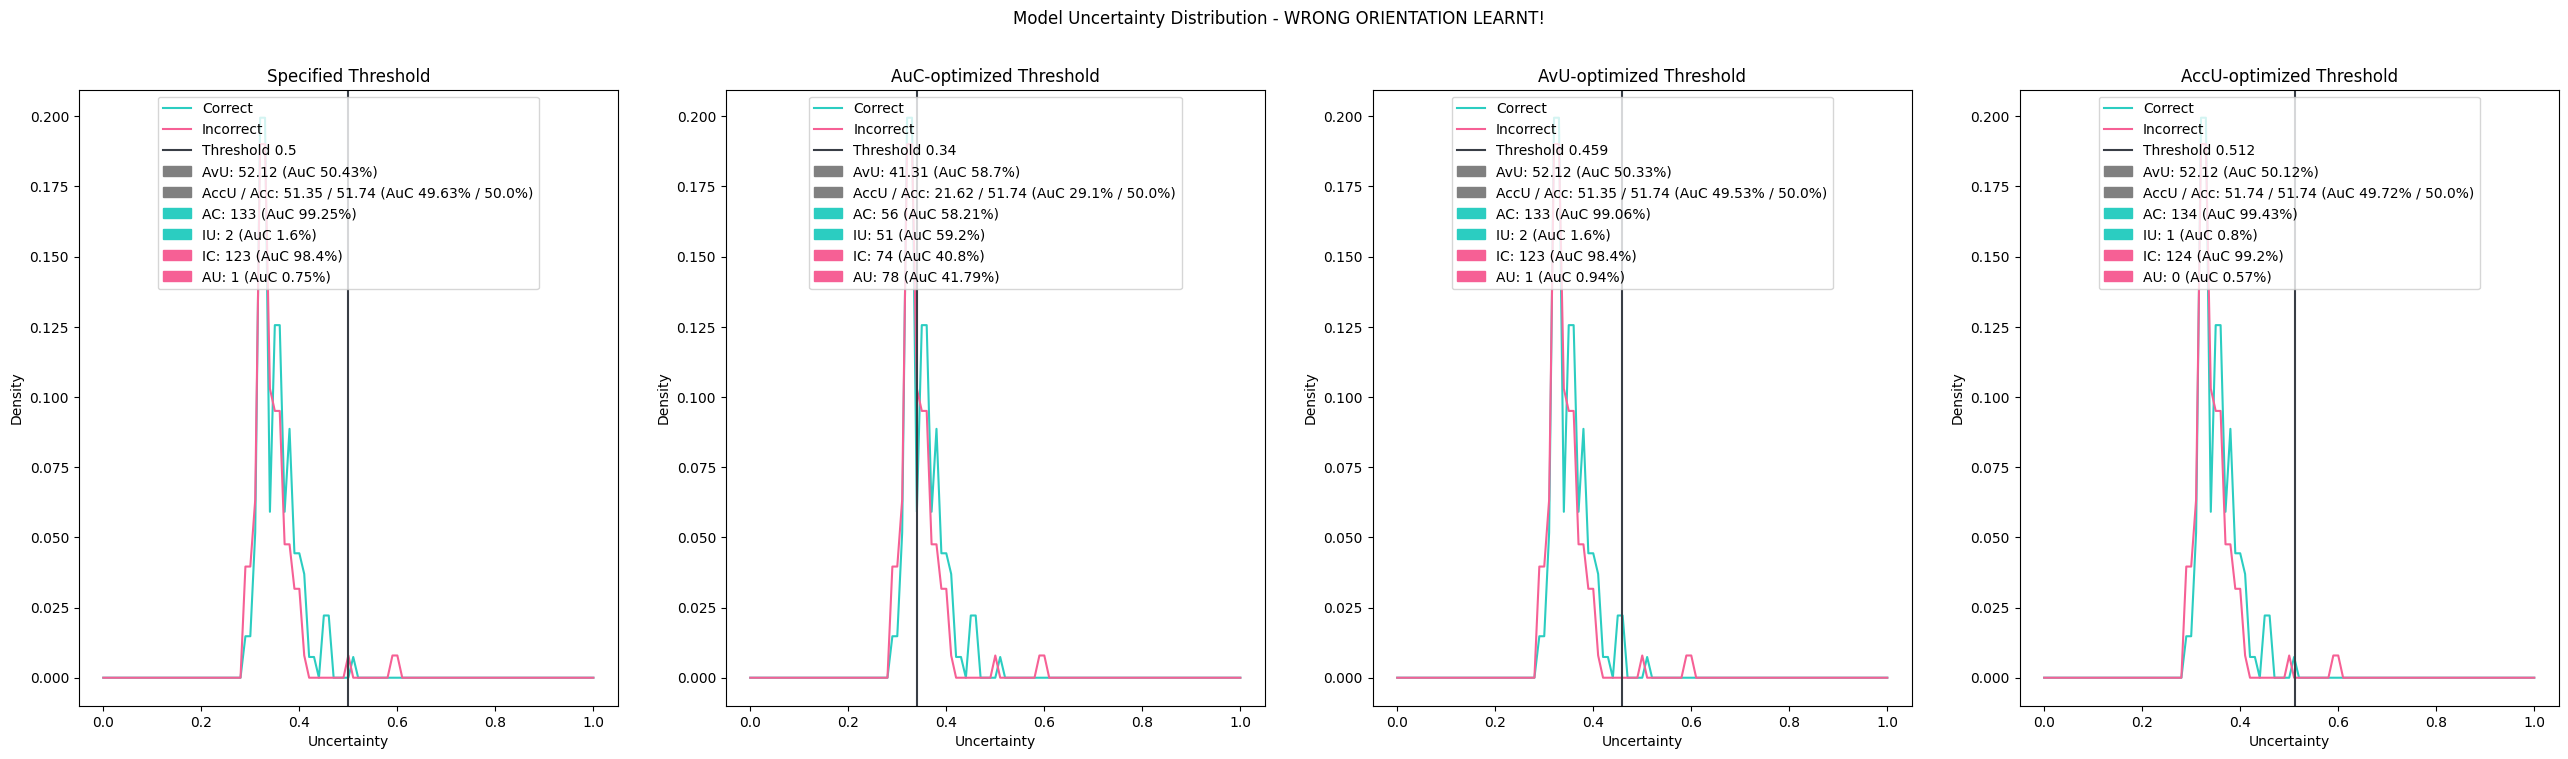

In [38]:
epoch = 0
phase = "Train"
correct = results[f"{phase}_correct"][epoch]
incorrect = results[f"{phase}_incorrect"][epoch]
fig, axs = plot_model_uncertainty_distribution(correct, incorrect, uncertainty_thresh, density=True)

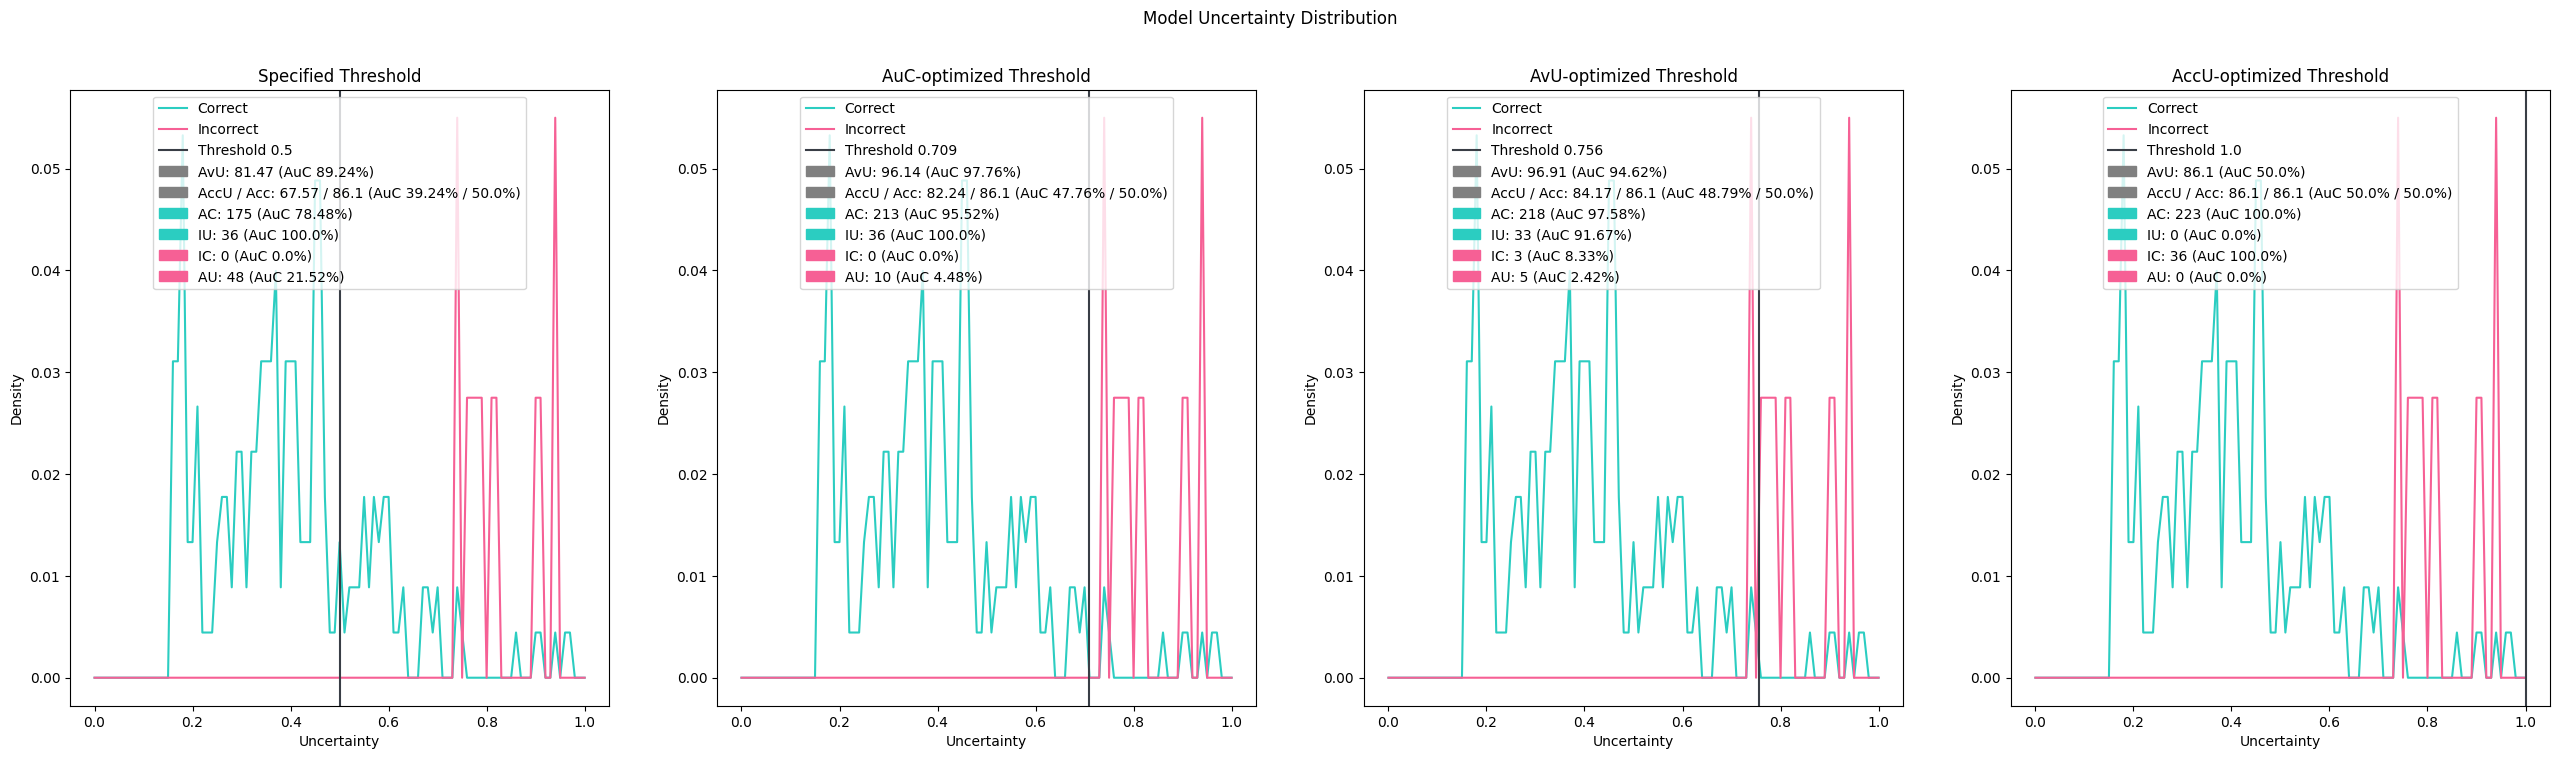

In [37]:
epoch = 24
phase = "Train"
correct = results[f"{phase}_correct"][epoch]
incorrect = results[f"{phase}_incorrect"][epoch]
fig, axs = plot_model_uncertainty_distribution(correct, incorrect, uncertainty_thresh, density=True)

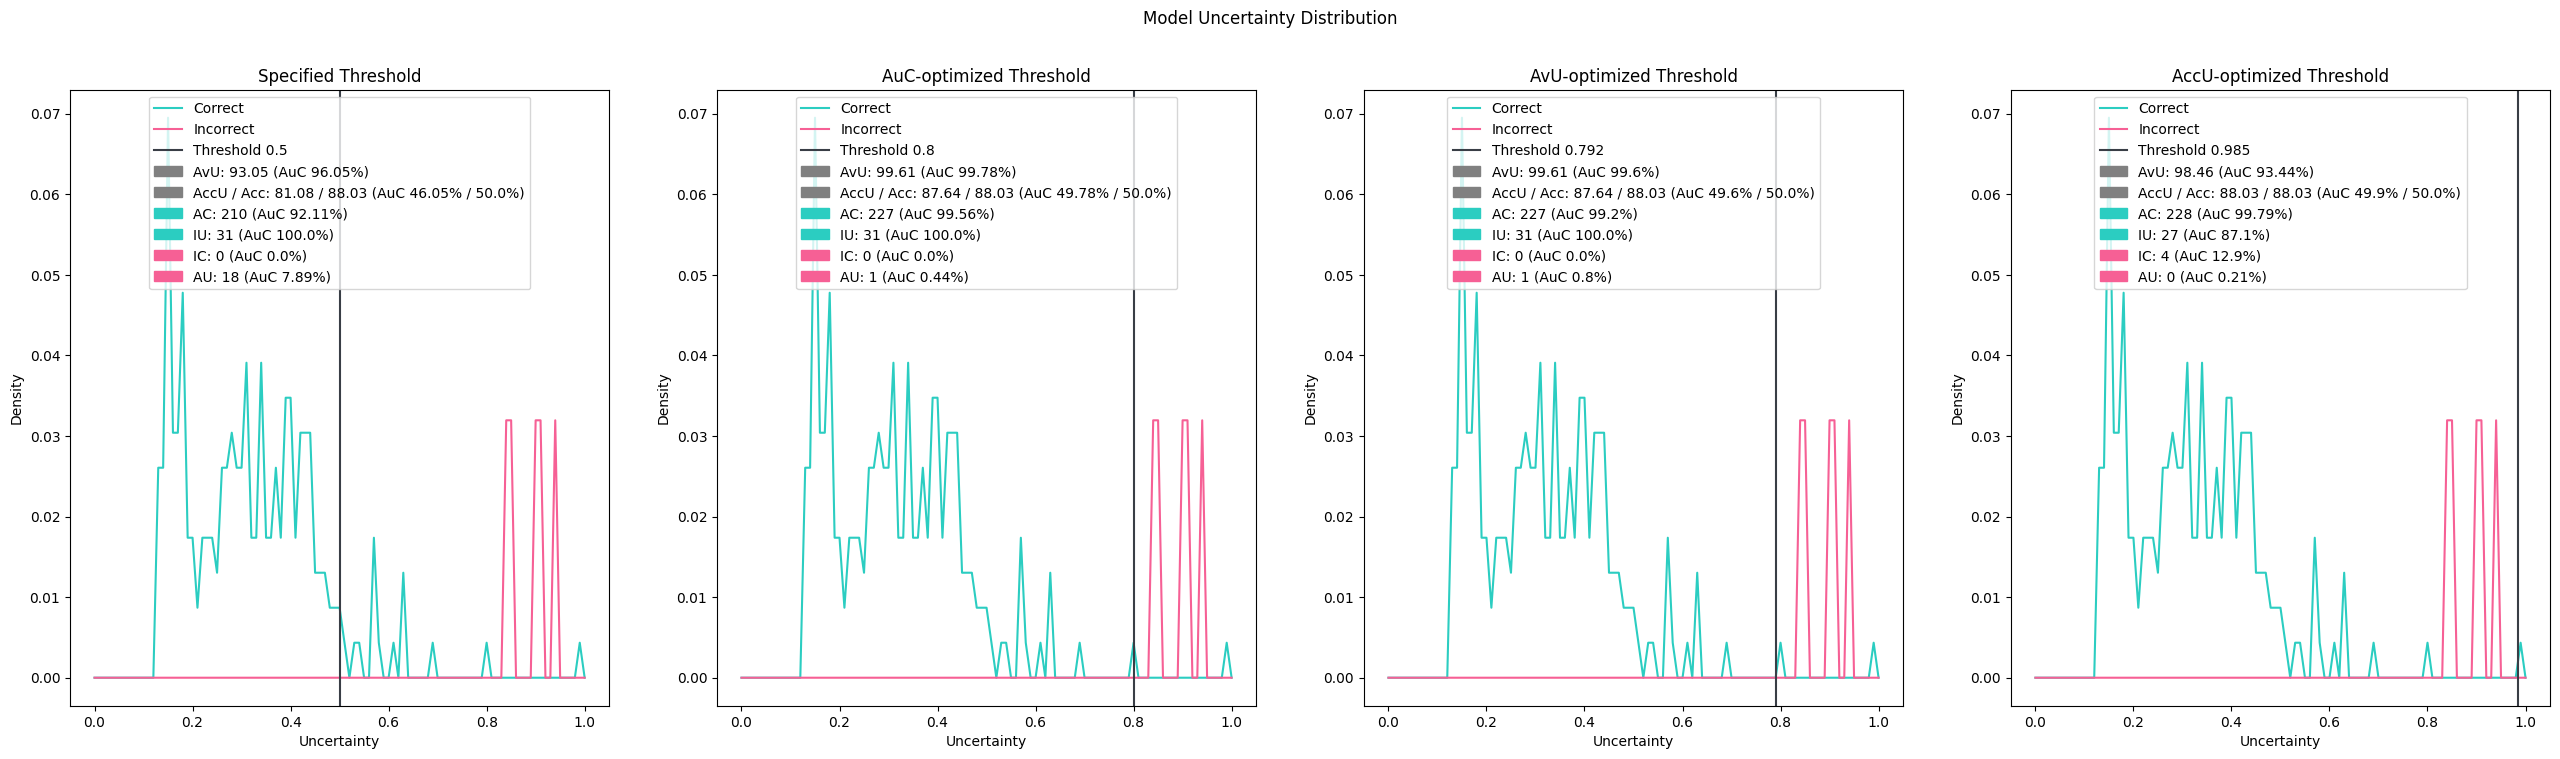

In [36]:
epoch = -1
phase = "Train"
correct = results[f"{phase}_correct"][epoch]
incorrect = results[f"{phase}_incorrect"][epoch]
fig, axs = plot_model_uncertainty_distribution(correct, incorrect, uncertainty_thresh, density=True)

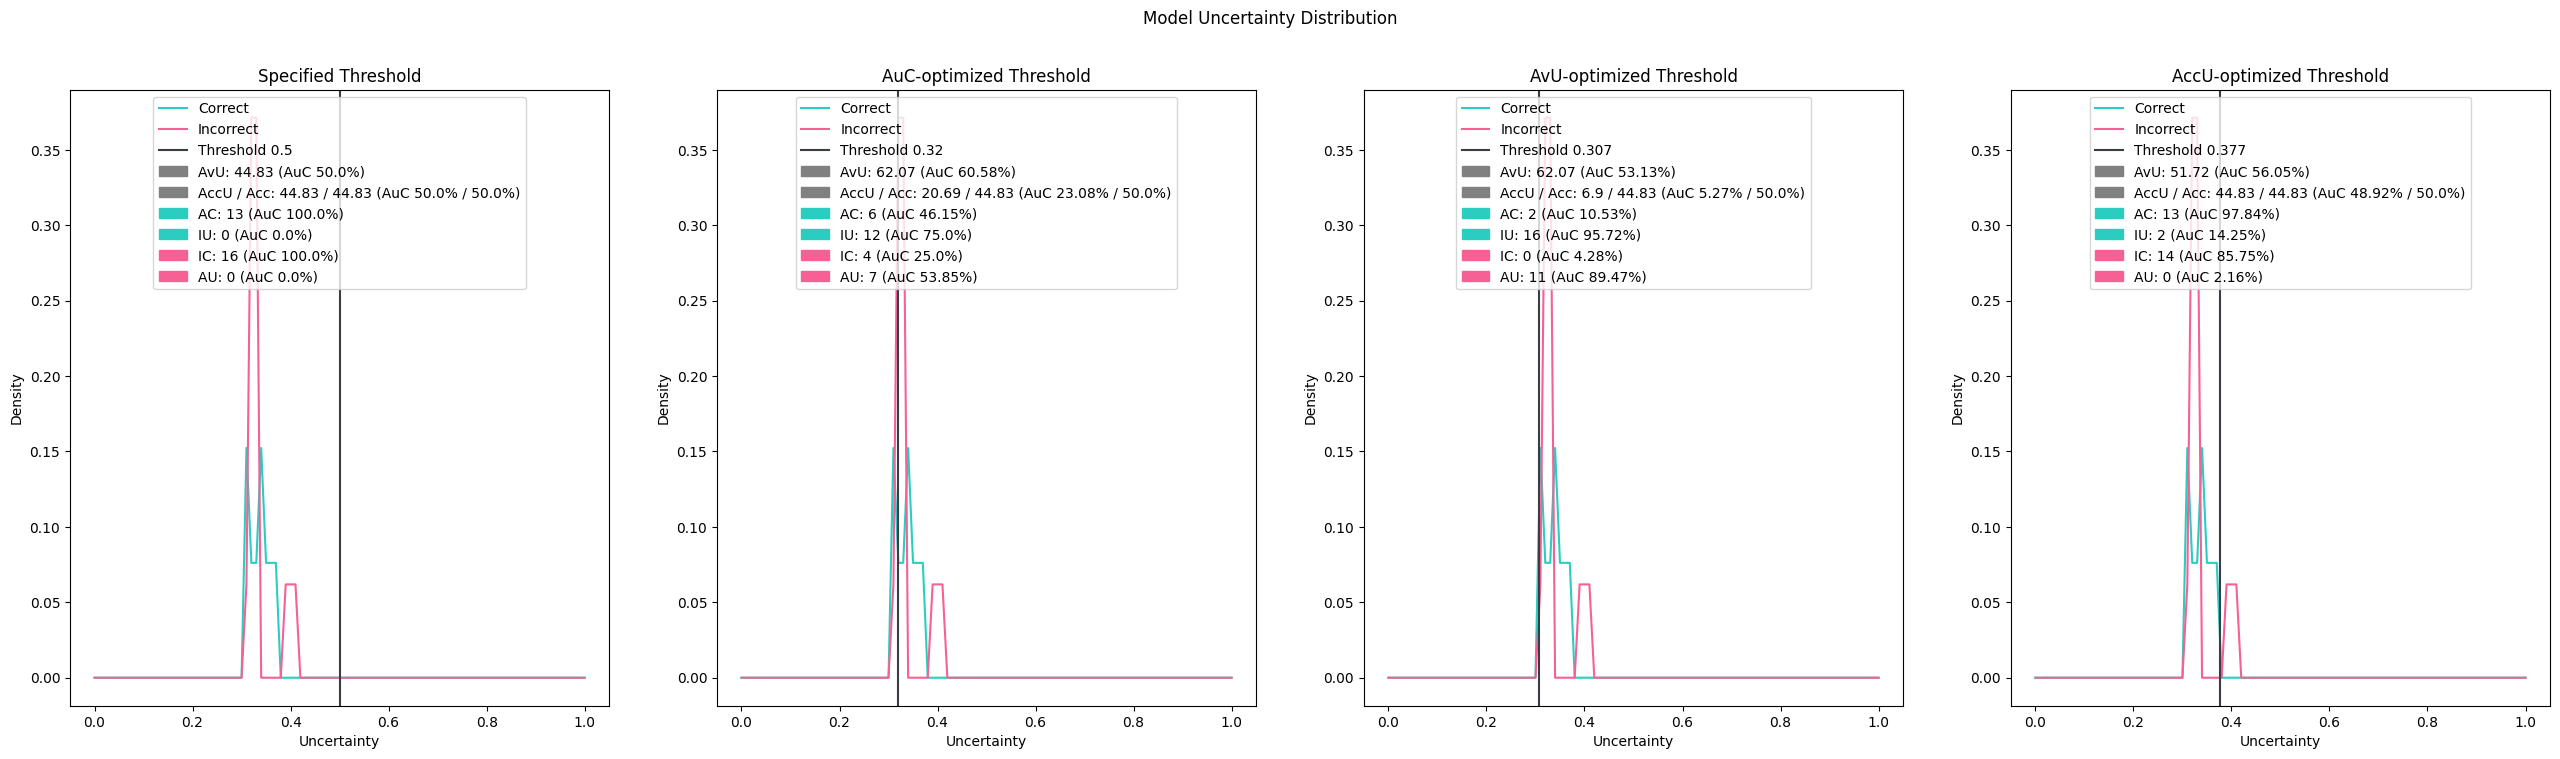

In [39]:
epoch = 0
phase = "Val"
correct = results[f"{phase}_correct"][epoch]
incorrect = results[f"{phase}_incorrect"][epoch]
fig, axs = plot_model_uncertainty_distribution(correct, incorrect, uncertainty_thresh, density=True)

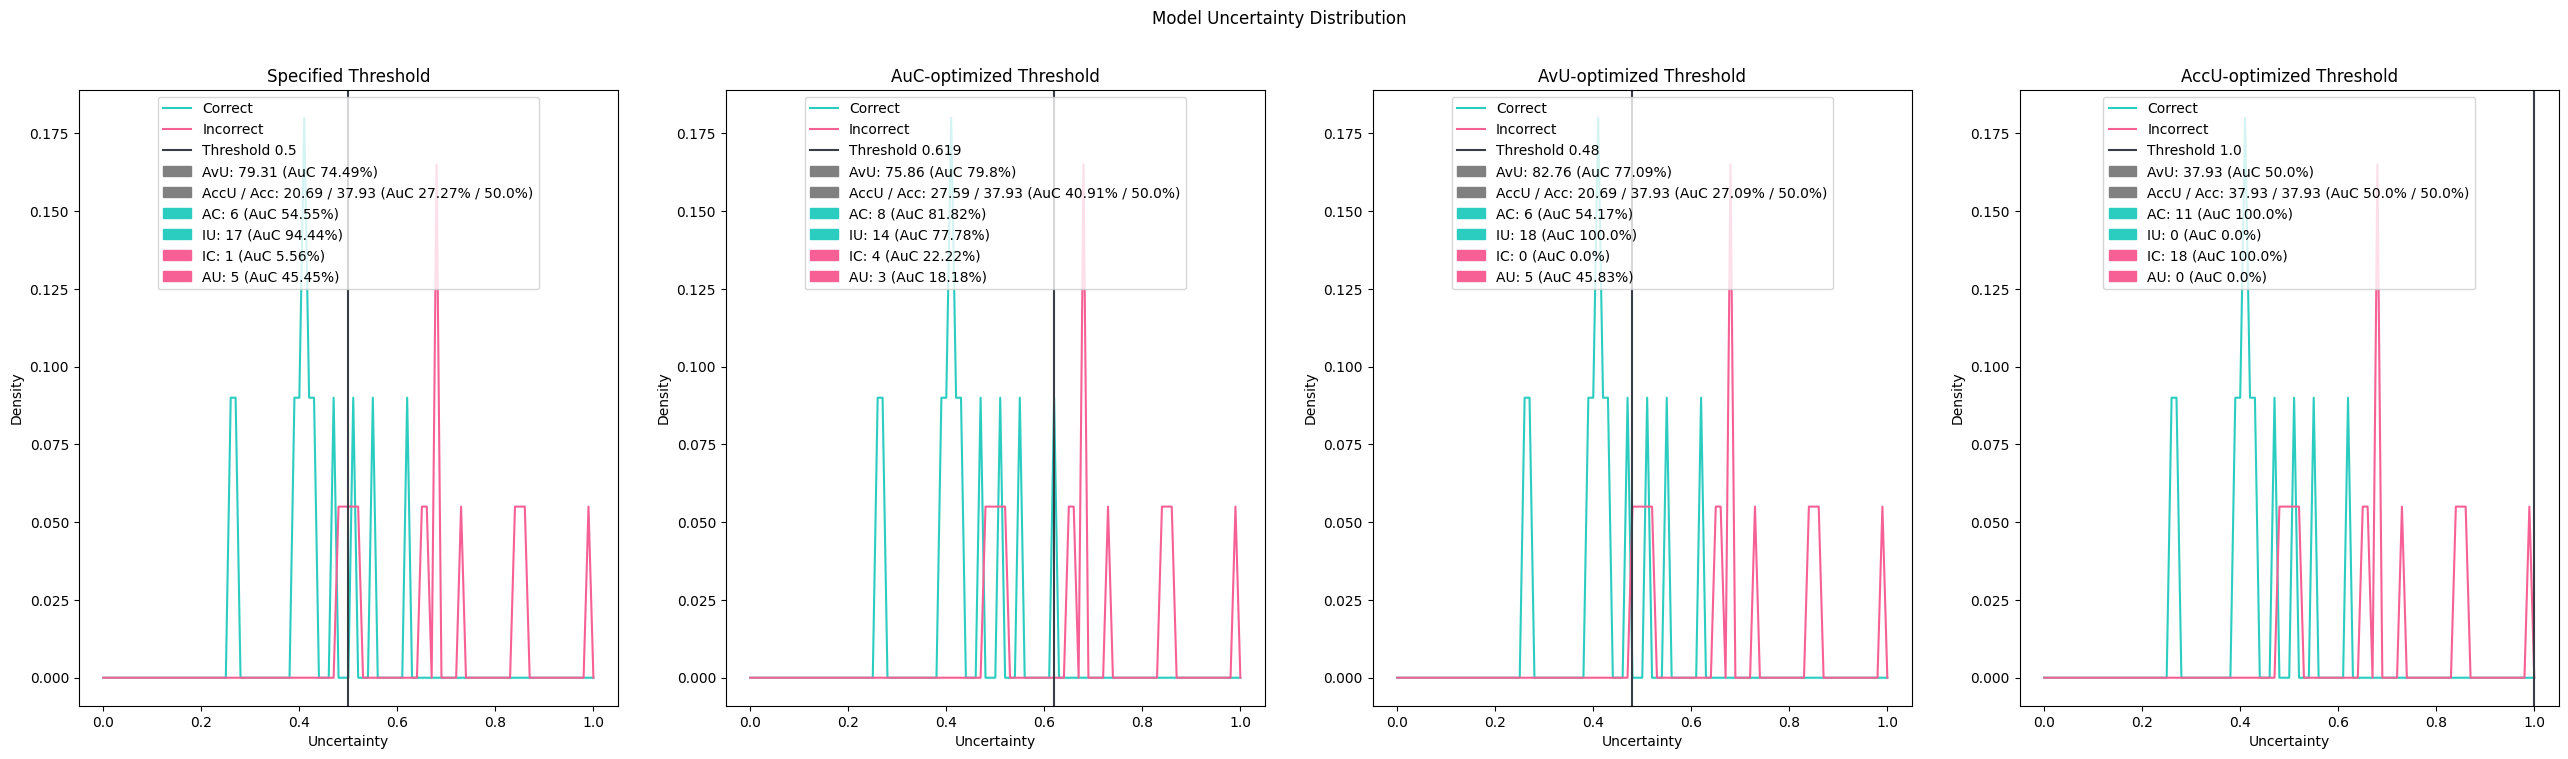

In [40]:
epoch = 24
phase = "Val"
correct = results[f"{phase}_correct"][epoch]
incorrect = results[f"{phase}_incorrect"][epoch]
fig, axs = plot_model_uncertainty_distribution(correct, incorrect, uncertainty_thresh, density=True)

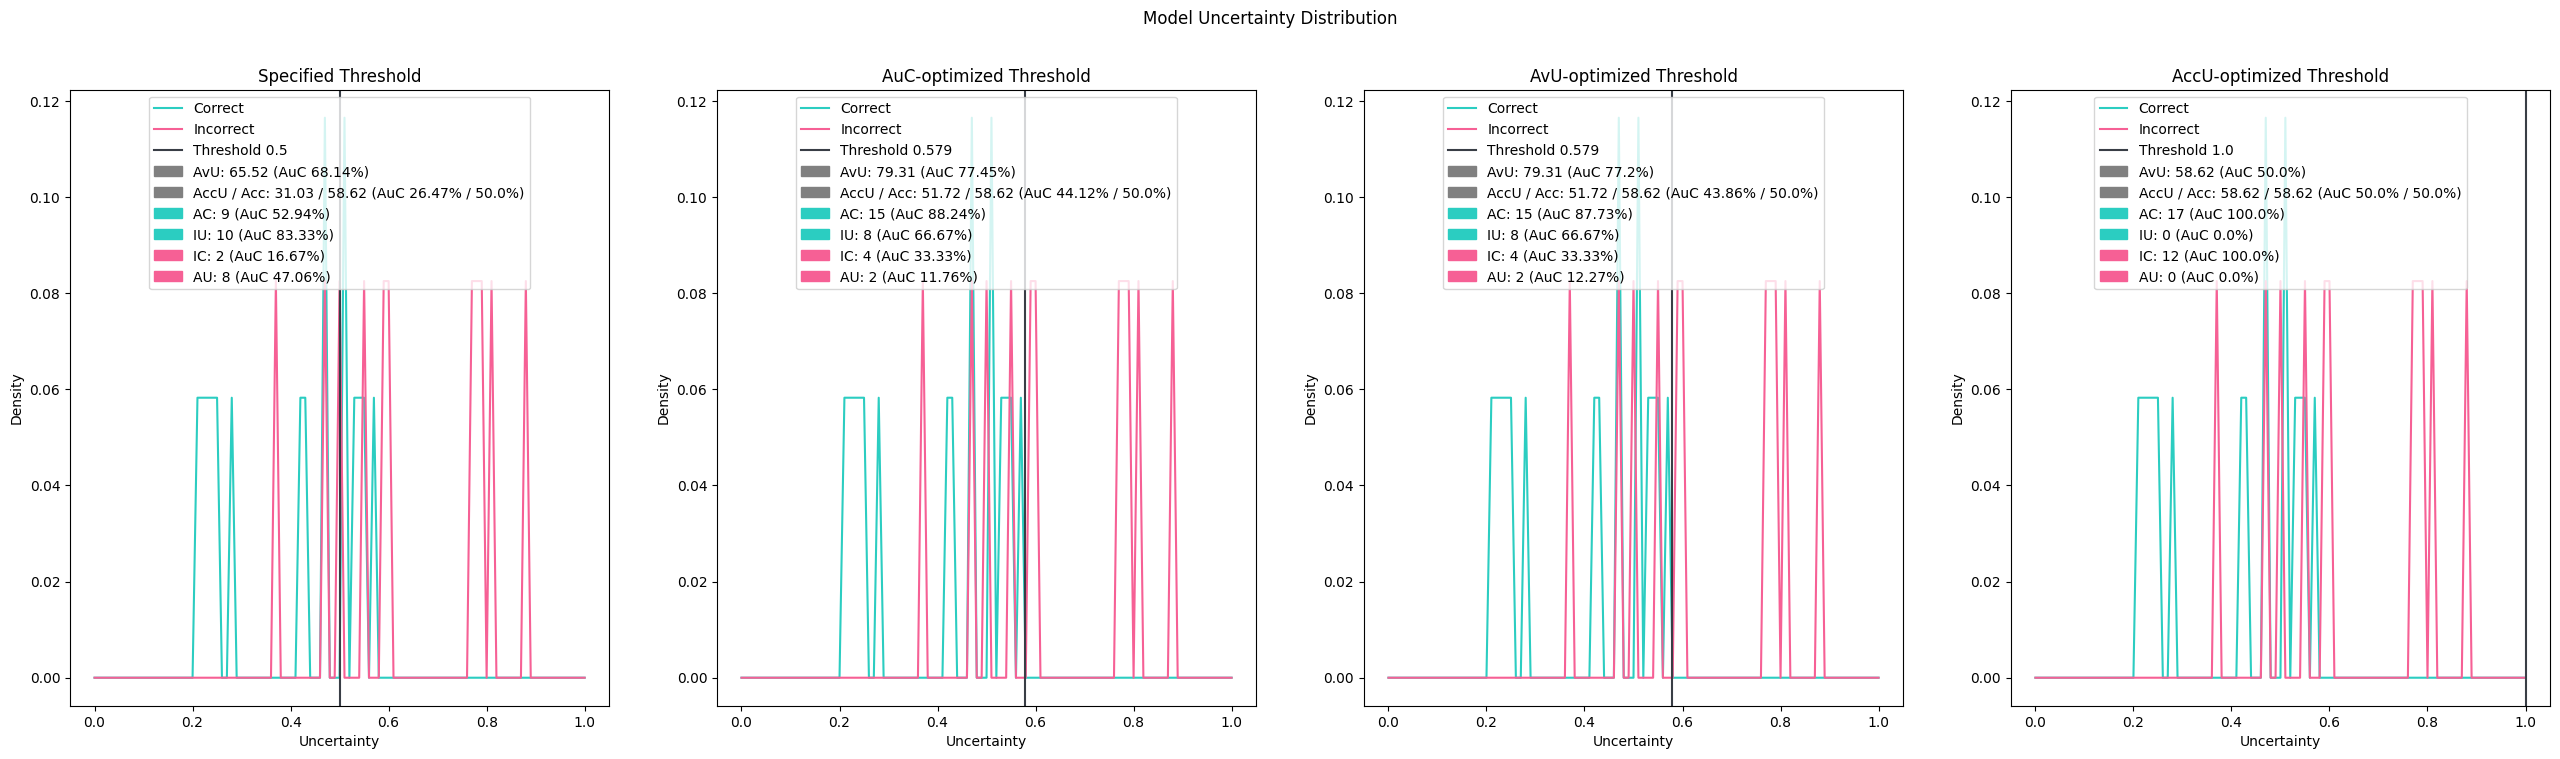

In [41]:
epoch = -1
phase = "Val"
correct = results[f"{phase}_correct"][epoch]
incorrect = results[f"{phase}_incorrect"][epoch]
fig, axs = plot_model_uncertainty_distribution(correct, incorrect, uncertainty_thresh, density=True)

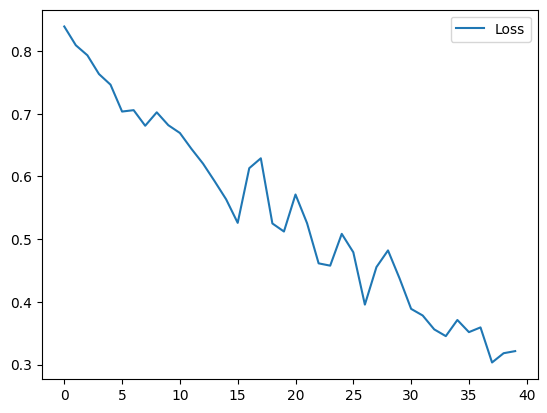

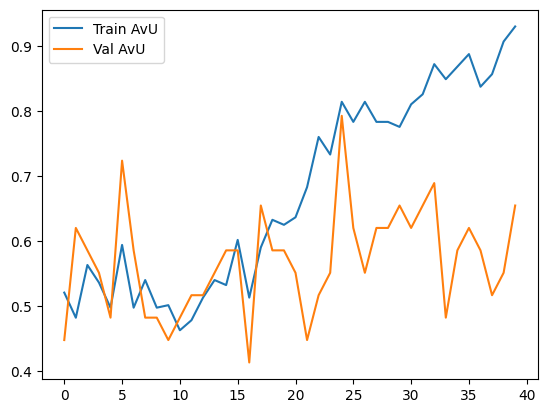

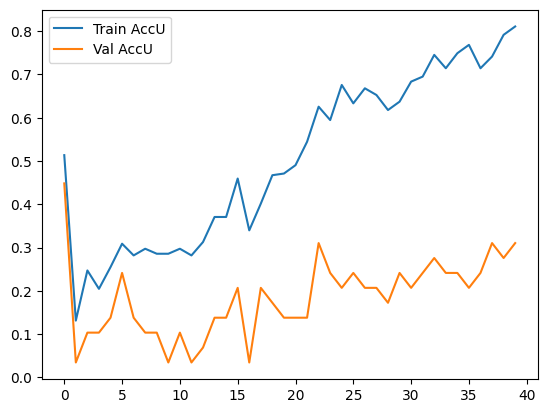

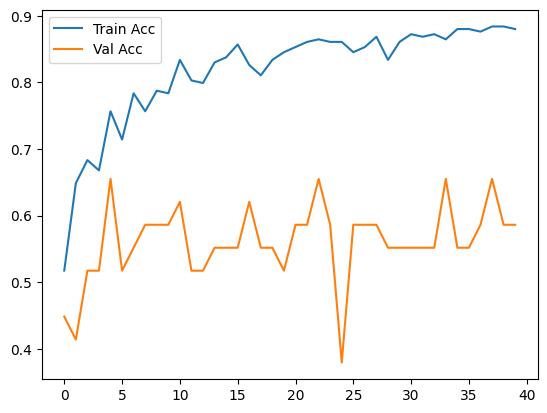

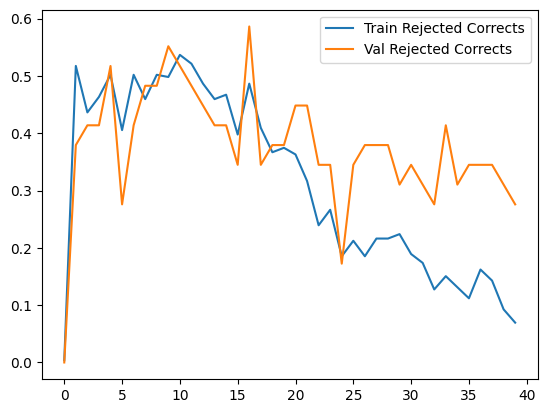

In [29]:
import matplotlib.pyplot as plt

start = 0

plt.plot(results["loss"][start:], label='Loss')
plt.legend()

plt.figure()
plt.plot(results["Train_AvU"][start:], label='Train AvU')
plt.plot(results["Val_AvU"][start:], label='Val AvU')
plt.legend()

plt.figure()
plt.plot(results["Train_AccU"][start:], label='Train AccU')
plt.plot(results["Val_AccU"][start:], label='Val AccU')
plt.legend()

plt.figure()
plt.plot(results["Train_Acc"][start:], label='Train Acc')
plt.plot(results["Val_Acc"][start:], label='Val Acc')
plt.legend()

plt.figure()
plt.plot(results["Train_SRC"][start:], label='Train Rejected Corrects')
plt.plot(results["Val_SRC"][start:], label='Val Rejected Corrects')
plt.legend()

# plt.figure()
# plt.plot(results["train_recall"][start:], label='Train Recall')
# plt.plot(results["val_recall"][start:], label='Val Recall')
# plt.legend()

# plt.figure()
# plt.plot(results["train_precision"][start:], label='Train Precision')
# plt.plot(results["val_precision"][start:], label='Val Precision')
# plt.legend()

# plt.figure()
# plt.plot(results["train_f_beta_score"][start:], label='Train F-Beta Score')
# plt.plot(results["val_f_beta_score"][start:], label='Val F-Beta Score')
# plt.legend()

In [30]:
name = []
[name.append("-".join(map(str, layer))) for layer in UNFREEZE_LAYERS]
if BALANCED:
    name.append("balanced")
name = ",".join(name)

In [31]:
accs = results["Val_accuracy"]
step = 10
print(f"| {name} | ")
print("| ------ | ")
[print(f"| {max(accs[:(i+1)*step]):.4f} | ") for i in range(len(accs)//step)]
print();

| 1-8 | 
| ------ | 
| 0.6552 | 
| 0.6552 | 
| 0.6552 | 
| 0.6552 | 



# Best Val Accs after N Epochs

1-8 = Unfreeze only Last Linear Layer of pretrained model\
weightedce = Weighted ce loss according to train dataset distribution\
bal = Balanced Train dataset

| ep | 1-5,1-8,ce | 1-8,ce | ce | 1-8,weightedce | 1-8,ce,bal | 1-8,focal | 1-8,focalcb | 1-8,sigmoidcb | 1-8,softmaxcb | 1-8,sse+kl,u<=0.5 |
| -- | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | 
| 10 | 0.5517 | 0.6207 | 0.6207 | 0.6552 | 0.4583 | 0.6552 | 0.5172 | 0.4828 | 0.4828 | 0.6552 | 
| 20 | 0.5517 | 0.6207 | 0.6207 | 0.6552 | 0.5417 | 0.6552 | 0.5862 | 0.6207 | 0.5517 | 0.6552 | 
| 30 | 0.5517 | 0.6897 | 0.6897 | 0.6552 | 0.5417 | 0.6552 | 0.6207 | 0.6207 | 0.6897 | 0.6552 | 
| 40 | 0.5517 | 0.6897 | 0.6897 | 0.6552 | 0.5417 | 0.6552 | 0.6207 | 0.6207 | 0.6897 | 0.6552 | 